# S&P 500 Data Set


## Abinav Kumar

In this notebook, I conduct exploratory data analysis on the 505 stocks composing the S&P 500 as of May 1st, 2019. The data is composed of two parts: daily log-returns from the begininning of 1999 to March 2018 and first quarter fundamentals for each stock. 

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns
import numpy as np
import datetime as dt

This is the dataset of log-returns. Each date is an observation of the returns for all the stocls.

In [4]:
# Import and touch up data
sp500 = pd.read_csv("Data/SP500.csv")
# Reset the index to date values
sp500.set_index('Unnamed: 0', inplace = True)
sp500.index.names = ['date']
sp500.set_index(pd.to_datetime(sp500.index), inplace = True)

sp500[sp500 == np.inf] = 0
sp500[sp500 == -np.inf] = 0

# Remove MMM because it has weird properties
sp500.drop('MMM', axis=1, inplace=True)

In [5]:
sp500.shape

(4839, 502)

In [6]:
sp500.head()

,ABT,ABBV,ACN,ATVI,AYI,ADBE,AMD,AAP,AES,AET,...,WYNN,XEL,XRX,XLNX,XL,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
1999-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-05,0.001230,NaN,NaN,-0.006455,NaN,-0.021454,-0.011133,NaN,-0.003890,0.025405,...,NaN,0.002184,0.018503,0.042135,-0.004131,NaN,0.019138,NaN,-0.001992,NaN
1999-01-06,-0.007609,NaN,NaN,0.017424,NaN,-0.036459,-0.016018,NaN,0.000000,0.033764,...,NaN,0.004716,0.018985,-0.008953,-0.057583,NaN,0.015172,NaN,0.000000,NaN
1999-01-07,-0.013091,NaN,NaN,-0.005469,NaN,0.020996,0.006948,NaN,-0.025975,0.038908,...,NaN,-0.004716,-0.004097,-0.007279,0.018362,NaN,-0.005032,NaN,-0.007337,NaN
1999-01-08,-0.003772,NaN,NaN,-0.011954,NaN,0.014030,0.020203,NaN,-0.037538,0.016843,...,NaN,-0.006933,-0.004938,0.000876,-0.042560,NaN,0.002620,NaN,0.002173,NaN


In [7]:
# Function to plot pretty histograms
def get_dist_graph(data, column, bins = 1000, title="Histogram"):
    fig, ax = plt.subplots(1, figsize=(15, 10))
    data_to_visualize = data[column][~data[column].isin([np.nan, np.inf, -np.inf])]
    mean = data_to_visualize.mean()
    std = data_to_visualize.std()
    minimum = data_to_visualize.min()
    maximum = data_to_visualize.max()
    sns.distplot(data_to_visualize, bins = bins, label = 'Mean : ' + str(round(mean, 2)))
    plt.xlim(max(mean - (3*std), minimum), min(mean + (3*std), maximum))
    plt.axvline(mean)
    plt.legend()
    plt.title(title)

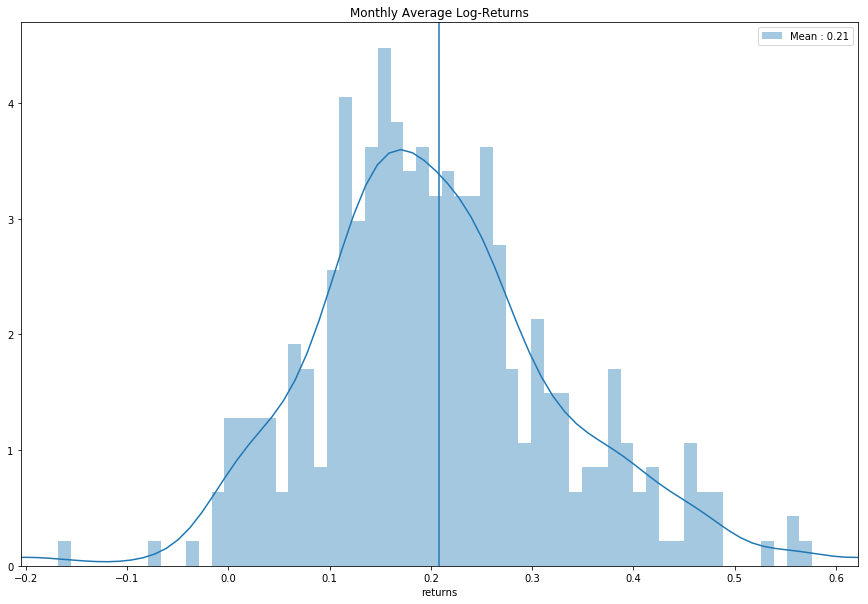

In [8]:
# Average monhtly returns
sp500_full = sp500.drop(sp500.index[0])
sp500_full.dropna(axis =1, how='any', inplace=True)
avg_mr = sp500_full.groupby(sp500_full.index.month).sum().mean().to_frame(name='returns')
get_dist_graph(avg_mr, 'returns', bins=100, title='Monthly Average Log-Returns')

## The Index

The S&P 500 is an index that tracks the market. These market indices are the benchmark for portfolio performance. Because we are using log-returns, sum-ing the row values gives the return level of holding the entire index as a portfolio.

In [21]:
# Create the index average returns
sp500_index = sp500.mean(axis=1)
sp500_index.head()

date
1999-01-04         NaN
1999-01-05    0.008743
1999-01-06    0.017829
1999-01-07   -0.003352
1999-01-08    0.004071
dtype: float64

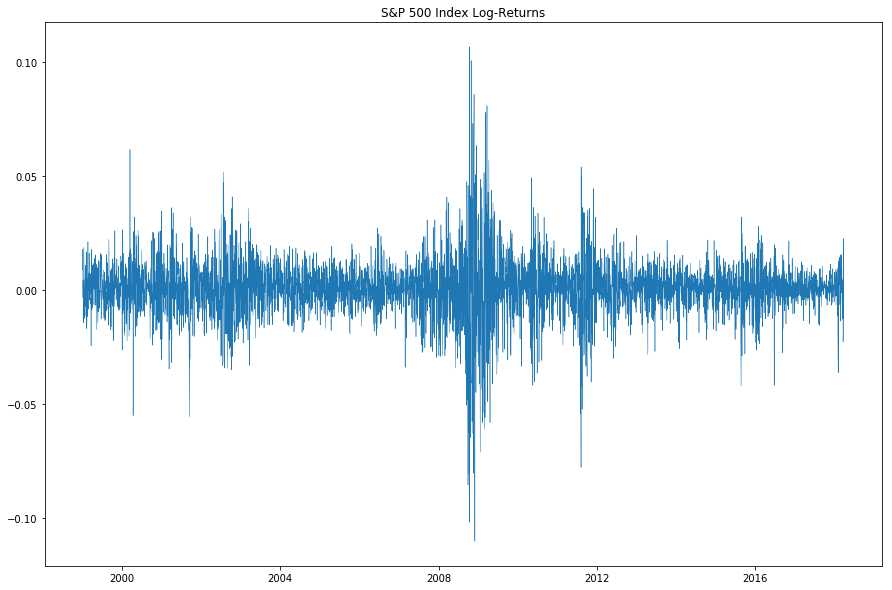

In [22]:
fig, ax = plt.subplots(1, figsize=(15, 10))
sns.lineplot(data=sp500_index, palette="tab10", linewidth=.5)
plt.title("S&P 500 Index Log-Returns")
plt.show()

As you can see above, the S&P 500 returns have blocks of chaotic returns. These chaotic blocks occur during events like the dot-com bubble, and the recession of 2008. These events can also be seen below.

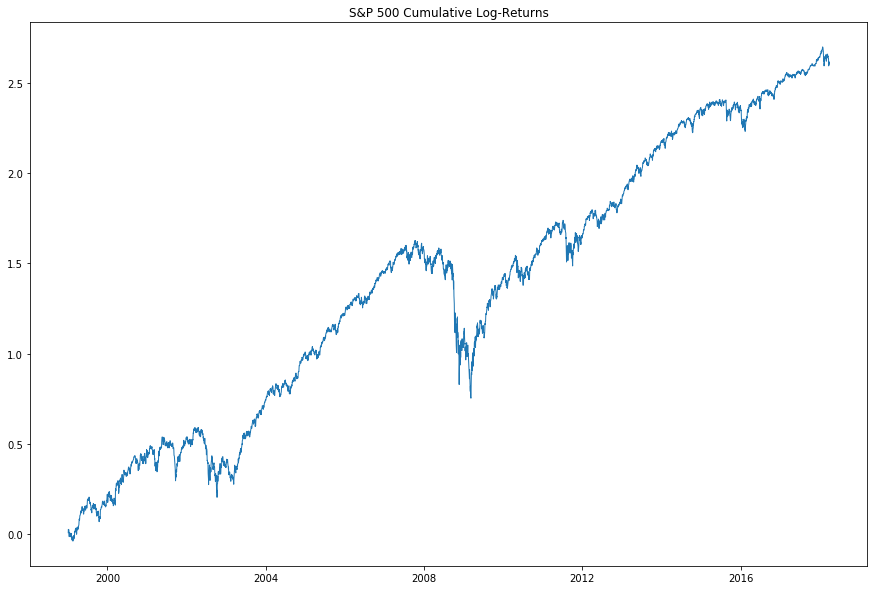

In [23]:
sp500_indexcumul = sp500_index.cumsum()
fig, ax = plt.subplots(1, figsize=(15, 10))
sns.lineplot(data=sp500_indexcumul, palette="tab10", linewidth=1)
plt.title("S&P 500 Cumulative Log-Returns")
plt.show()

Here, I construct a graph that shows the average annual returns for all the stocks. It helps better understand what occured to the market on a yearly basis.

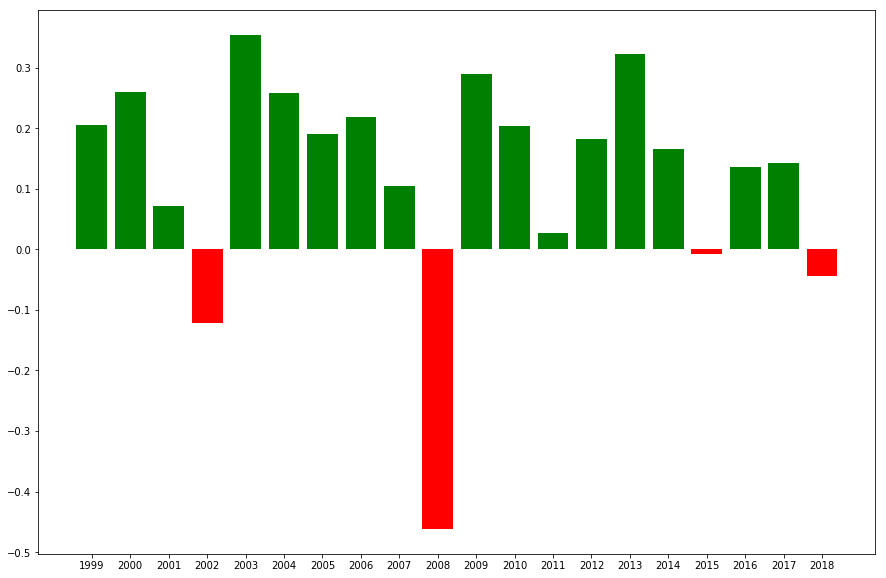

In [12]:
avg_year_ret = sp500_full.groupby(sp500_full.index.year).sum().mean(axis=1)
green = avg_year_ret > 0
fig, ax = plt.subplots(1, figsize=(15, 10))
plt.bar(avg_year_ret.index[green], height=avg_year_ret[green], color="green")
plt.bar(avg_year_ret.index[~green], height=avg_year_ret[~green], color="red")
plt.xticks(avg_year_ret.index)
plt.show()

# Seasonal Decomposition

To see the effects of the time of year, I remove the monthly seasonal trend. This graph shows the baseline trend and the seasonal trend that stacks on to theoretically replicate the observed series. 

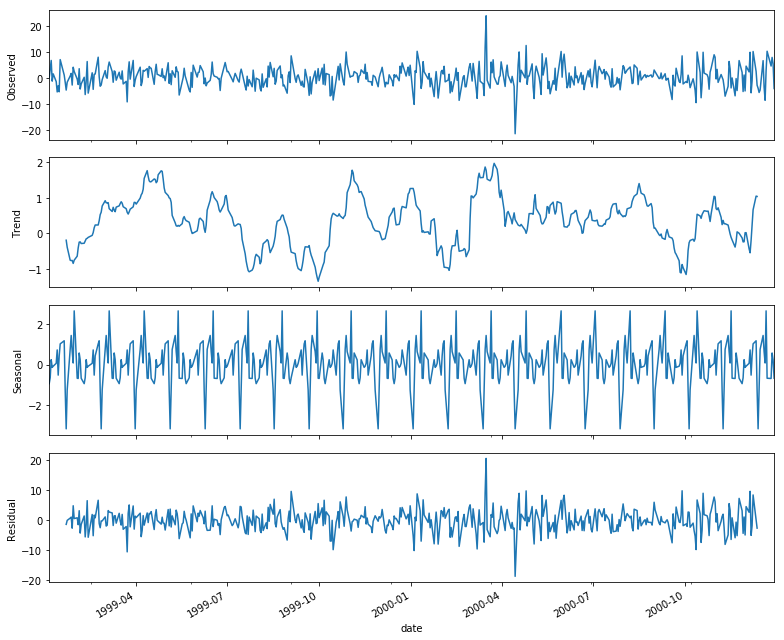

<Figure size 7200x4320 with 0 Axes>

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

results = seasonal_decompose(sp500_index[:504], model='additive', freq=24)
results.plot()
plt.figure(figsize=(100,60))
plt.show()

# Looking at Correlations

Using only the stocks with the full 20 years of data, I calculate the correlation matrix of the stocks. I found the 93.75th percentile of the summed correlations of the stocks. I then drew a heat map of the top 6.25 percent's correlations.

In [14]:
corr_mat = sp500_full.corr()
corr_mat.sum().describe([.9375])

count    372.000000
mean      92.107674
std       20.710328
min       34.196686
50%       90.502763
93.8%    124.348562
max      135.041311
dtype: float64

In [15]:
main_corr = corr_mat.sum()[corr_mat.sum() > 124]

In [16]:
def get_corr_heat_map(data, ignore_cancelled = True):
    data_to_visualize = data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]
    corr = data_to_visualize.corr()
    fig, ax = plt.subplots(figsize=(15, 10))
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.show()

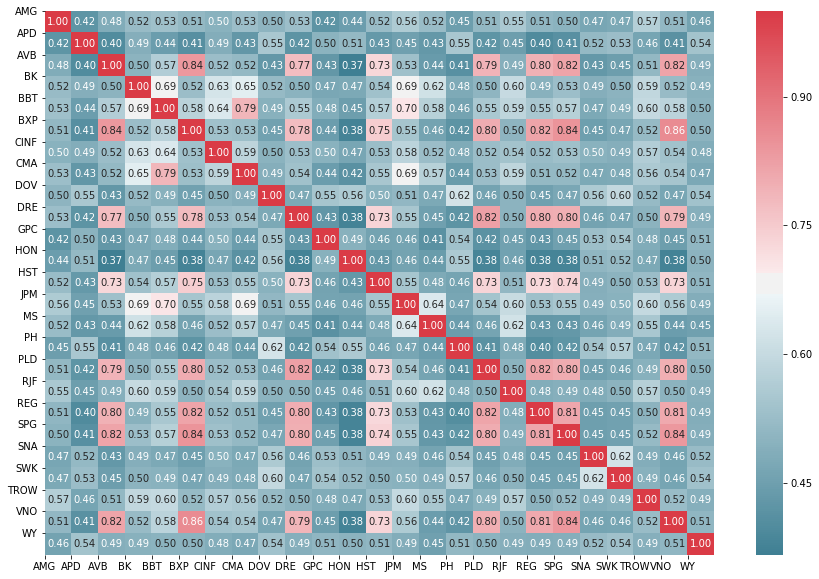

In [17]:
main_corr_mat = sp500_full.loc[:,main_corr.index]
get_corr_heat_map(main_corr_mat, ignore_cancelled = False)

It is not expected to find a correlation between the lagged return of one stock and a present value of returns of another stock. This is because of market efficiency. A correlation would result in market exploitation which would lead to a deviation from the high correlation.

In [18]:
lag_corr = sp500_full.loc[:,main_corr.index].corr()

for i in sp500_full.loc[:,main_corr.index]:
    returns = sp500_full[i]
    returns = returns.values[1:len(returns)]
    returns = np.append(returns,0)
    temp_df = sp500_full.loc[:,main_corr.index]
    temp_df[i] = returns
    lag_corr[i] = temp_df.corr()[i]

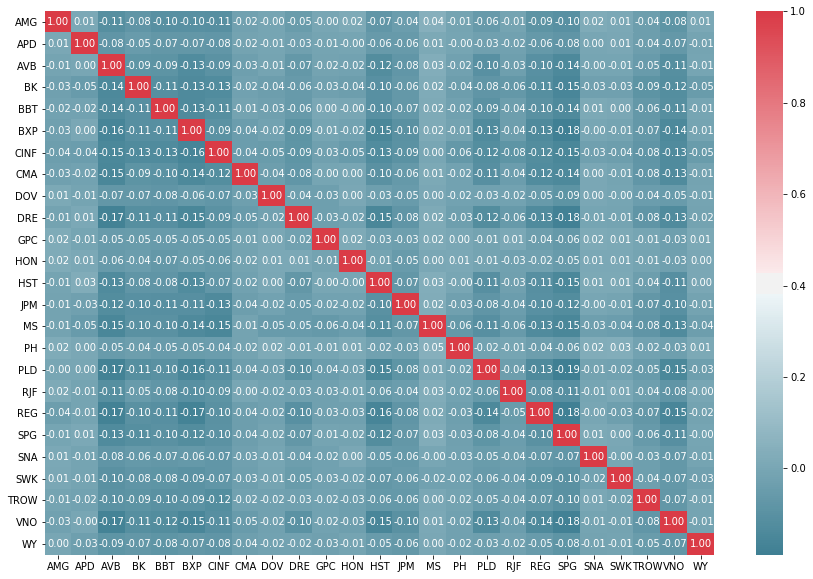

In [19]:
fig, ax = plt.subplots(figsize=(15, 10))
colormap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(lag_corr, cmap=colormap, annot=True, fmt=".2f")
plt.show()